<a href="https://colab.research.google.com/github/sarithamiryala/DeepLearningClassifier/blob/main/sugarcaneplantdisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

akilesh253_sugarcane_plant_diseases_dataset_path = kagglehub.dataset_download('akilesh253/sugarcane-plant-diseases-dataset')
saritham_sugarcane_test_images_path = kagglehub.dataset_download('saritham/sugarcane-test-images')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from transformers import ViTForImageClassification, ViTFeatureExtractor
from tqdm import tqdm

In [ ]:
!pip install split-folders

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
import splitfolders

input_folder = "/kaggle/input/sugarcane-plant-diseases-dataset/Sugarcane_leafs"
splitfolders.ratio(input_folder, output="/kaggle/working/sugarcanedisease", seed=42, ratio=(0.7, 0.15, 0.15), group_prefix=None)

Copying files: 19926 files [03:18, 100.34 files/s]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (256, 256)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=90,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.2)

val_test_datagen = ImageDataGenerator(rescale=1./255)


#----------------------------------------

train_generator = train_datagen.flow_from_directory('/kaggle/working/sugarcanedisease/train',
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

val_generator = val_test_datagen.flow_from_directory('/kaggle/working/sugarcanedisease/val',
                                                target_size=IMG_SIZE,
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical')

test_generator = val_test_datagen.flow_from_directory('/kaggle/working/sugarcanedisease/test',
                                                  target_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 13946 images belonging to 6 classes.
Found 2986 images belonging to 6 classes.
Found 2994 images belonging to 6 classes.


In [ ]:
import os
import torch
from torchvision import datasets, transforms

# Define data directories
data_dir = '/kaggle/working/sugarcanedisease'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# Define data transformations
# Corresponding to Keras ImageDataGenerator parameters
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.RandomRotation(90),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
        transforms.ToTensor(),
        # No need for rescale=1./255 because ToTensor() does that
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        # No need for rescale=1./255 because ToTensor() does that
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        # No need for rescale=1./255 because ToTensor() does that
    ]),
}

# Create datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [ ]:
# from collections import Counter

# # Assuming train_dataset, val_dataset, and test_dataset are already created using ImageFolder
# # Combine all datasets to get the total count per class
# all_datasets = train_dataset + val_dataset + test_dataset

# # Get the class indices from the datasets
# class_counts = Counter([label for _, label in all_datasets])

# # Map class indices back to class names
# class_names = train_dataset.classes  # Classes are the same for all splits
# class_counts_mapped = {class_names[class_idx]: count for class_idx, count in class_counts.items()}

# # Print the count for each class
# print("Image count per class:")
# for class_name, count in class_counts_mapped.items():
#     print(f"{class_name}: {count}")


Image count per class:
BacterialBlights: 4800
Healthy: 3132
Mosaic: 2772
RedRot: 3108
Rust: 3084
Yellow: 3030


In [ ]:
# Print dataset sizes
print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')

Training dataset size: 13946
Validation dataset size: 2986


In [ ]:
train_dataset.classes

['BacterialBlights', 'Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']

In [ ]:
# Load the feature extractor and the model
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(train_dataset.classes))

# Move the model to the GPU if available
model.to(device)

# Print the model architecture
print(model)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
# # Load the feature extractor and the model
# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(train_dataset.classes))

# # Clear GPU cache to free up memory
# torch.cuda.empty_cache()

# # Reduce batch size in your dataloaders (e.g., to 16 or 8)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# # Move the model to the GPU if available
# model.to(device)

# # Print the model architecture
# print(model)

In [ ]:
# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# # Training loop
# num_epochs = 10


# train_losses = []
# val_losses = []
# train_accuracies = []
# val_accuracies = []

# for epoch in range(num_epochs):
#     # Training phase
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0

#     for inputs, labels in tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}'):
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad()

#         outputs = model(inputs).logits
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * inputs.size(0)
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     epoch_loss = running_loss / len(train_loader.dataset)
#     epoch_acc = correct / total
#     train_losses.append(epoch_loss)
#     train_accuracies.append(epoch_acc)

#     print(f'Training - Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop
num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}'):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # If your model returns logits directly, you can use outputs = model(inputs)
        # If your model returns a dictionary, adjust accordingly
        outputs = model(inputs).logits if hasattr(model(inputs), 'logits') else model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # **Fixed print statement with matching quotation marks**
    print(f'Training - Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f'Validation Epoch {epoch+1}/{num_epochs}'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).logits if hasattr(model(inputs), 'logits') else model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f'Validation - Epoch {epoch+1}/{num_epochs}, Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}')

    # Step the scheduler
    scheduler.step()

Training Epoch 1/10:   0%|          | 0/872 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training Epoch 1/10:   4%|▍         | 38/872 [00:27<10:00,  1.39it/s]


KeyboardInterrupt: 

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop
num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}'):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # If your model returns logits directly, you can use outputs = model(inputs)
        # If your model returns a dictionary, adjust accordingly
        outputs = model(inputs).logits if hasattr(model(inputs), 'logits') else model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # **Fixed print statement with matching quotation marks**
    print(f'Training - Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f'Validation Epoch {epoch+1}/{num_epochs}'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).logits if hasattr(model(inputs), 'logits') else model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f'Validation - Epoch {epoch+1}/{num_epochs}, Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}')

    # Step the scheduler
    scheduler.step()

Training Epoch 1/10: 100%|██████████| 872/872 [10:27<00:00,  1.39it/s]


Training - Epoch 1/10, Loss: 0.4526, Accuracy: 0.8491


Validation Epoch 1/10: 100%|██████████| 187/187 [01:07<00:00,  2.79it/s]


Validation - Epoch 1/10, Loss: 0.3404, Accuracy: 0.8831


Training Epoch 2/10: 100%|██████████| 872/872 [10:27<00:00,  1.39it/s]


Training - Epoch 2/10, Loss: 0.2670, Accuracy: 0.9059


Validation Epoch 2/10: 100%|██████████| 187/187 [01:06<00:00,  2.80it/s]


Validation - Epoch 2/10, Loss: 0.2686, Accuracy: 0.9019


Training Epoch 3/10: 100%|██████████| 872/872 [10:28<00:00,  1.39it/s]


Training - Epoch 3/10, Loss: 0.2237, Accuracy: 0.9188


Validation Epoch 3/10: 100%|██████████| 187/187 [01:06<00:00,  2.79it/s]


Validation - Epoch 3/10, Loss: 0.1643, Accuracy: 0.9451


Training Epoch 4/10: 100%|██████████| 872/872 [10:28<00:00,  1.39it/s]


Training - Epoch 4/10, Loss: 0.1942, Accuracy: 0.9299


Validation Epoch 4/10: 100%|██████████| 187/187 [01:06<00:00,  2.80it/s]


Validation - Epoch 4/10, Loss: 0.1610, Accuracy: 0.9424


Training Epoch 5/10: 100%|██████████| 872/872 [10:28<00:00,  1.39it/s]


Training - Epoch 5/10, Loss: 0.1723, Accuracy: 0.9377


Validation Epoch 5/10: 100%|██████████| 187/187 [01:07<00:00,  2.79it/s]


Validation - Epoch 5/10, Loss: 0.1618, Accuracy: 0.9481


Training Epoch 6/10: 100%|██████████| 872/872 [10:28<00:00,  1.39it/s]


Training - Epoch 6/10, Loss: 0.1449, Accuracy: 0.9475


Validation Epoch 6/10: 100%|██████████| 187/187 [01:07<00:00,  2.78it/s]


Validation - Epoch 6/10, Loss: 0.1658, Accuracy: 0.9377


Training Epoch 7/10: 100%|██████████| 872/872 [10:28<00:00,  1.39it/s]


Training - Epoch 7/10, Loss: 0.1377, Accuracy: 0.9531


Validation Epoch 7/10: 100%|██████████| 187/187 [01:07<00:00,  2.79it/s]


Validation - Epoch 7/10, Loss: 0.1573, Accuracy: 0.9457


Training Epoch 8/10: 100%|██████████| 872/872 [10:28<00:00,  1.39it/s]


Training - Epoch 8/10, Loss: 0.0728, Accuracy: 0.9742


Validation Epoch 8/10: 100%|██████████| 187/187 [01:07<00:00,  2.79it/s]


Validation - Epoch 8/10, Loss: 0.1109, Accuracy: 0.9578


Training Epoch 9/10: 100%|██████████| 872/872 [10:28<00:00,  1.39it/s]


Training - Epoch 9/10, Loss: 0.0533, Accuracy: 0.9824


Validation Epoch 9/10: 100%|██████████| 187/187 [01:06<00:00,  2.80it/s]


Validation - Epoch 9/10, Loss: 0.1080, Accuracy: 0.9615


Training Epoch 10/10: 100%|██████████| 872/872 [10:28<00:00,  1.39it/s]


Training - Epoch 10/10, Loss: 0.0478, Accuracy: 0.9834


Validation Epoch 10/10: 100%|██████████| 187/187 [01:07<00:00,  2.78it/s]

Validation - Epoch 10/10, Loss: 0.0966, Accuracy: 0.9645


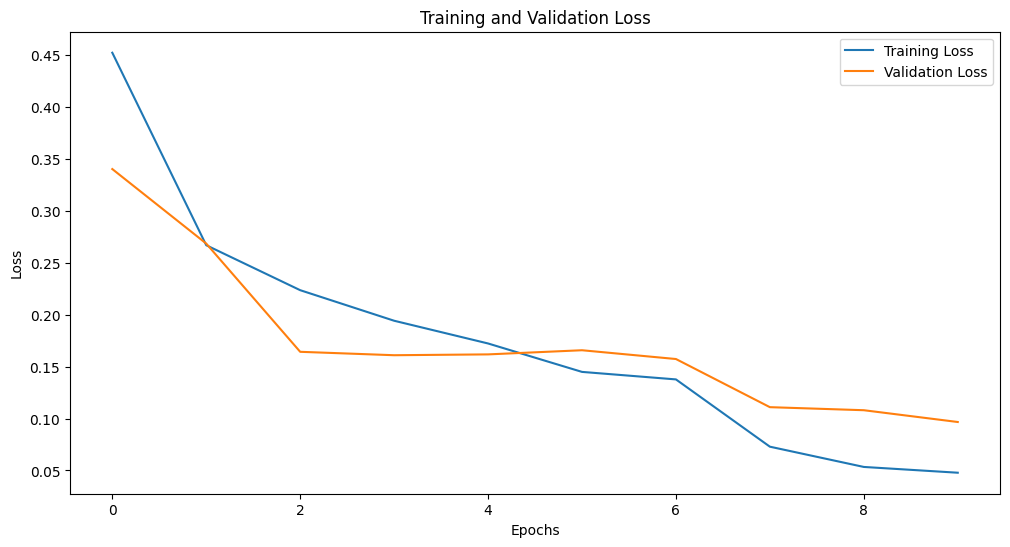

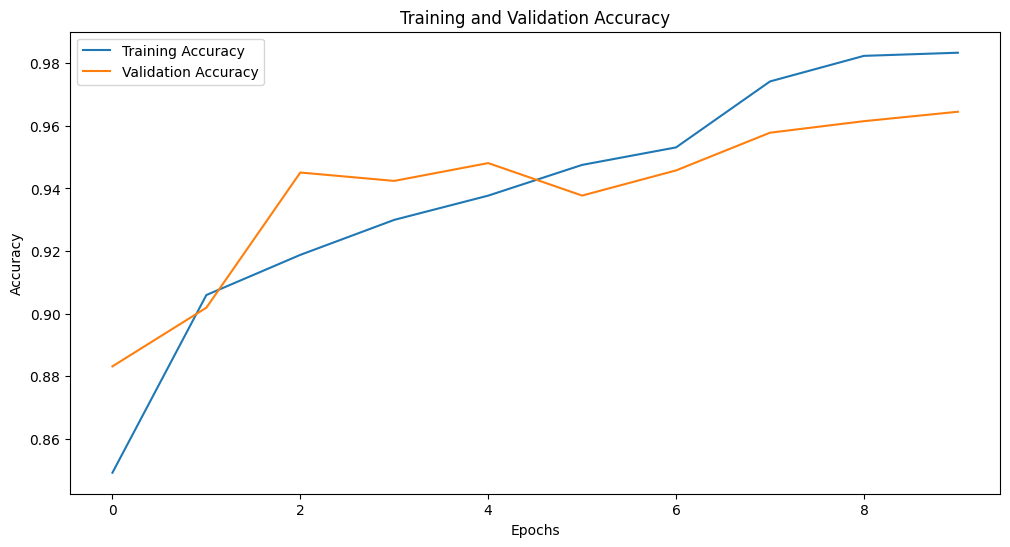

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

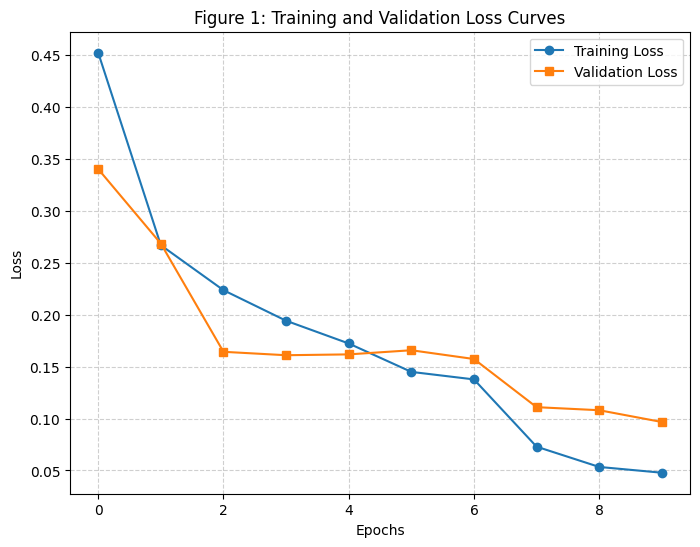

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.title('Figure 1: Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.savefig('training_validation_loss.png')  # Save as an image
plt.show()

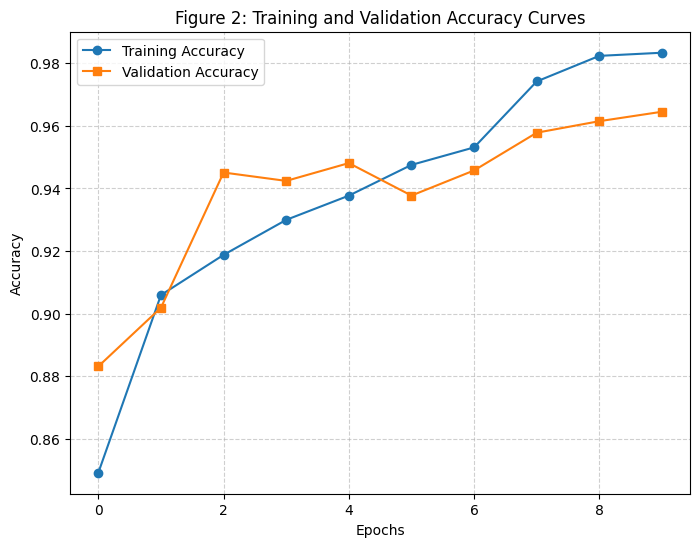

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='s')
plt.title('Figure 2: Training and Validation Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.savefig('training_validation_accuracy.png')  # Save as an image
plt.show()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


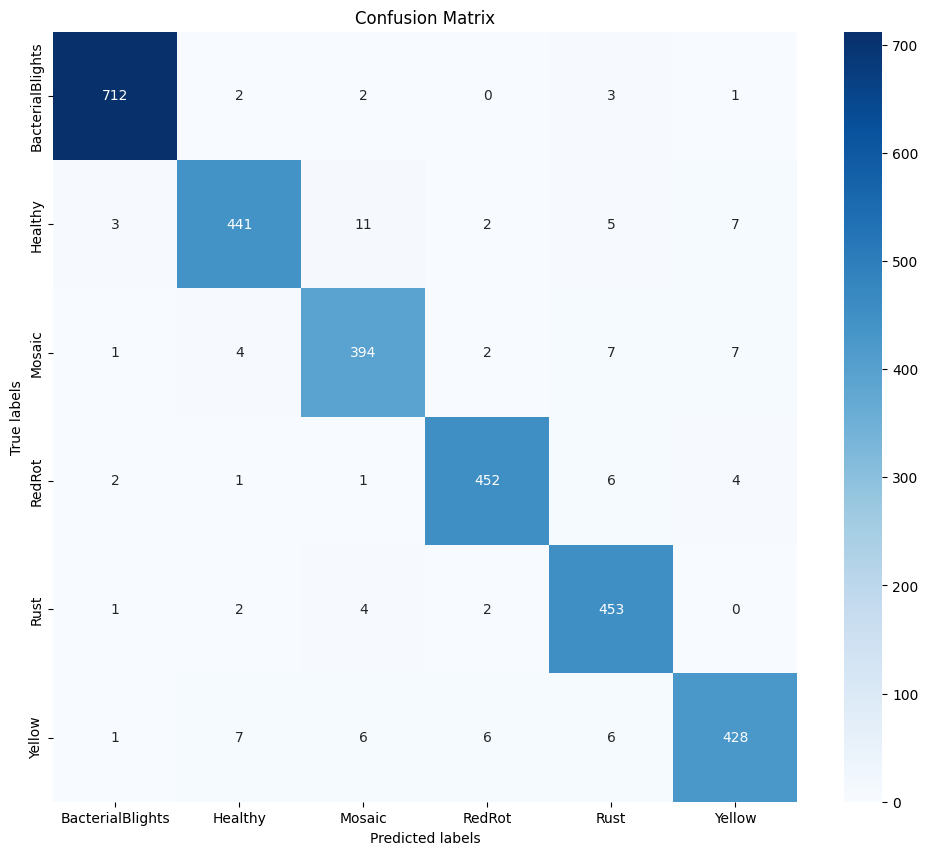

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect all the true labels and predicted labels for the validation set
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).logits
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

. Training Time Analysis

Plot Training Time per Epoch:
Description: Provides insight into the computational efficiency and resource requirements.
Implementation: Record the time taken for each epoch during training.

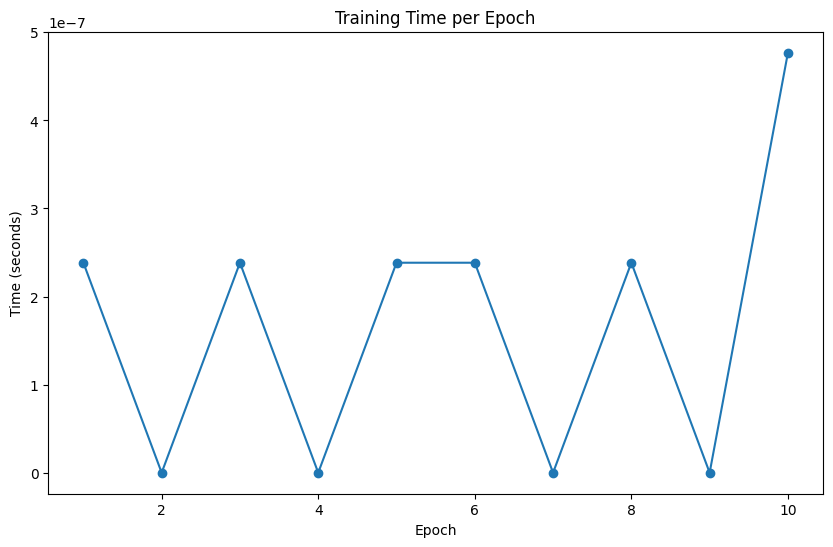

In [ ]:
import time

training_times = []
for epoch in range(num_epochs):
    start_time = time.time()
    # Training code...
    epoch_time = time.time() - start_time
    training_times.append(epoch_time)
# Plotting
plt.figure(figsize=(10,6))
plt.plot(range(1, num_epochs+1), training_times, marker='o')
plt.title('Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.show()

 Misclassified Samples Analysis

Visualize and Analyze Misclassified Images:
Description: Identify and display examples where the model made incorrect predictions. This helps in understanding the challenges and potential areas for improvement.


In [ ]:
class_names = train_dataset.classes

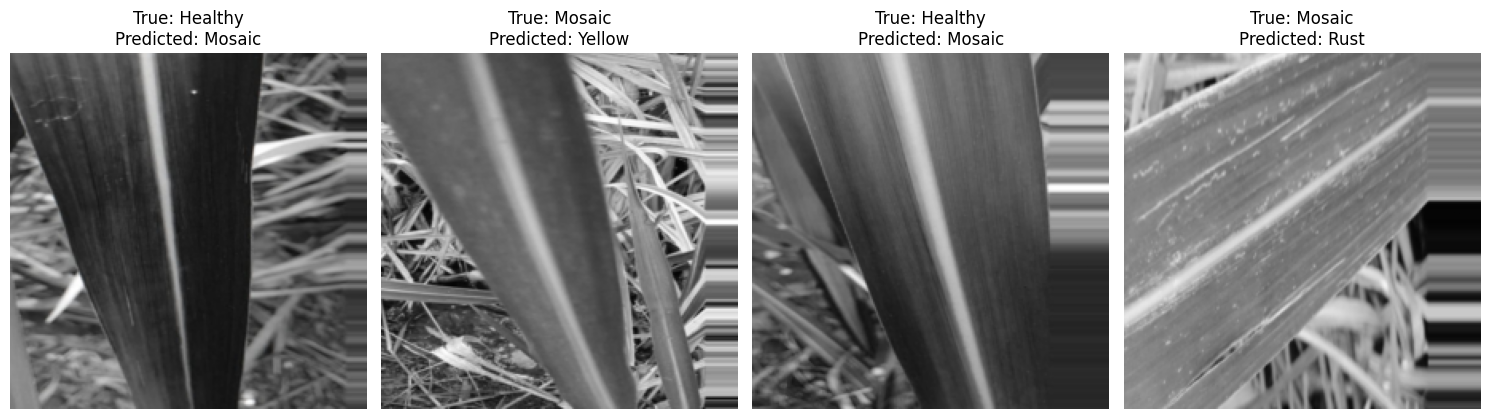

In [ ]:
import random

# Find misclassified indices
misclassified_indices = [i for i, (pred, true) in enumerate(zip(all_preds, all_labels)) if pred != true]
# Randomly select a few misclassified samples
samples = random.sample(misclassified_indices, min(4, len(misclassified_indices)))

fig, axes = plt.subplots(1, len(samples), figsize=(15,5))
for idx, i in enumerate(samples):
    img, label = val_dataset[i]
    axes[idx].imshow(img.permute(1, 2, 0))
    axes[idx].set_title(f'True: {class_names[all_labels[i]]}\nPredicted: {class_names[all_preds[i]]}')
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

Receiver Operating Characteristic (ROC) Curves and AUC

Plot ROC Curves for Each Class:
Description: ROC curves provide insight into the true positive rate versus false positive rate at various threshold settings.


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Initialize lists to store true labels and predicted scores
all_labels = []
all_outputs = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        logits = outputs.logits  # Assuming outputs has attribute 'logits'

        all_labels.extend(labels.cpu().numpy())
        all_outputs.extend(logits.cpu().numpy())

# Convert lists to NumPy arrays
y_true = np.array(all_labels)
y_score = np.array(all_outputs)

print(f'y_true shape: {y_true.shape}')    # Should be (num_samples,)
print(f'y_score shape: {y_score.shape}')  # Should be (num_samples, n_classes)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


y_true shape: (2986,)
y_score shape: (2986, 6)


Sample Augmentation Visualization

Show Examples of Augmented Images:
Description: Visualize how your data augmentation techniques modify the original images. This demonstrates the variability introduced to help the model generalize better.

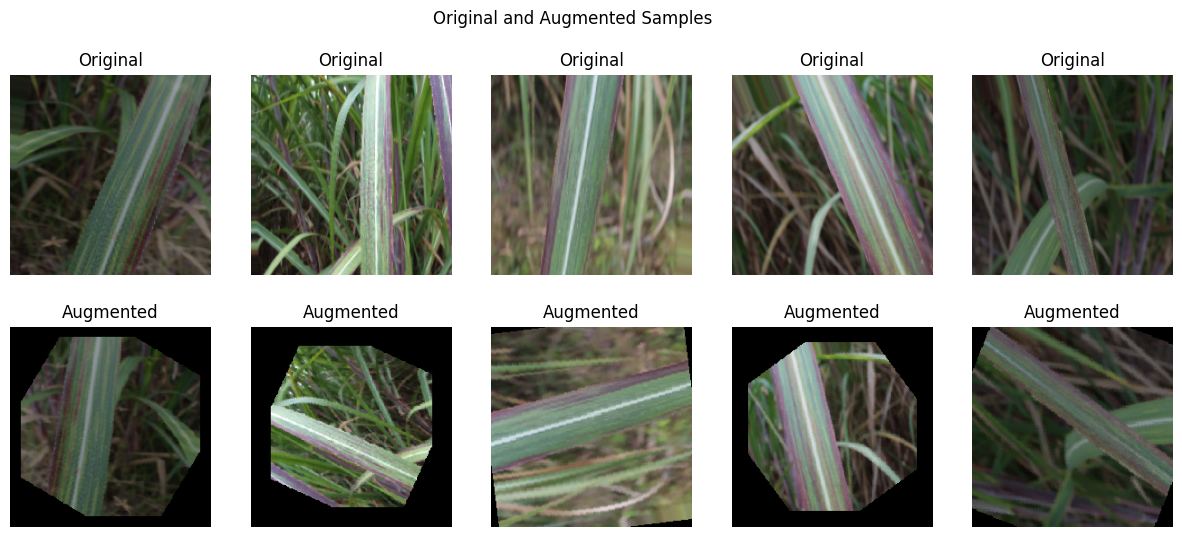

In [ ]:
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import Image

# Define image size
IMG_SIZE = (224, 224)

# Define your augmentation transforms (without ToTensor())
aug_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
])

# Create an untransformed dataset to access original images
untransformed_dataset = datasets.ImageFolder(train_dir)

# Visualize augmentations for first 5 images
fig, axes = plt.subplots(2, 5, figsize=(15,6))
for idx in range(5):
    img_path, label = untransformed_dataset.samples[idx]
    img = Image.open(img_path).convert('RGB')

    augmented_img = aug_transforms(img)

    # Original image
    axes[0, idx].imshow(img)
    axes[0, idx].axis('off')
    axes[0, idx].set_title('Original')

    # Augmented image
    axes[1, idx].imshow(augmented_img)
    axes[1, idx].axis('off')
    axes[1, idx].set_title('Augmented')

plt.suptitle('Original and Augmented Samples')
plt.show()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


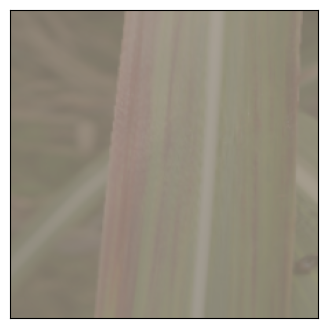

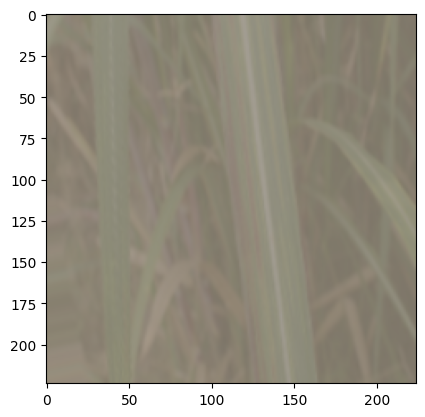

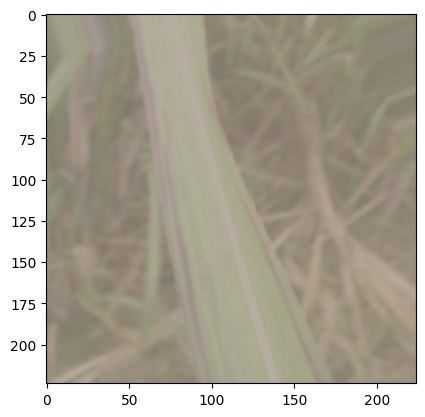

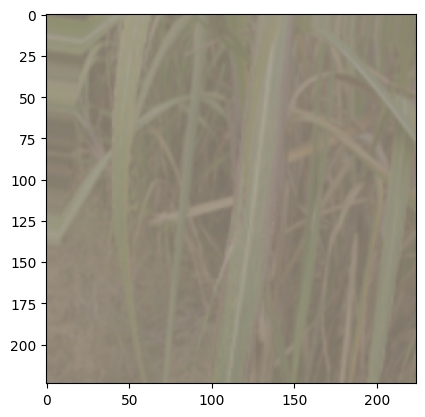

In [ ]:

# Function to show an image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of validation data
inputs, classes = next(iter(val_loader))

# Make predictions
outputs = model(inputs.to(device)).logits
_, preds = torch.max(outputs, 1)

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
    imshow(inputs.cpu().data[idx])
    ax.set_title(f"Predicted: {train_dataset.classes[preds[idx]]}\nTrue: {train_dataset.classes[classes[idx]]}")

In [ ]:
# Save the model
torch.save(model.state_dict(), '/kaggle/working//vit_sugarcane_disease_detection.pth')

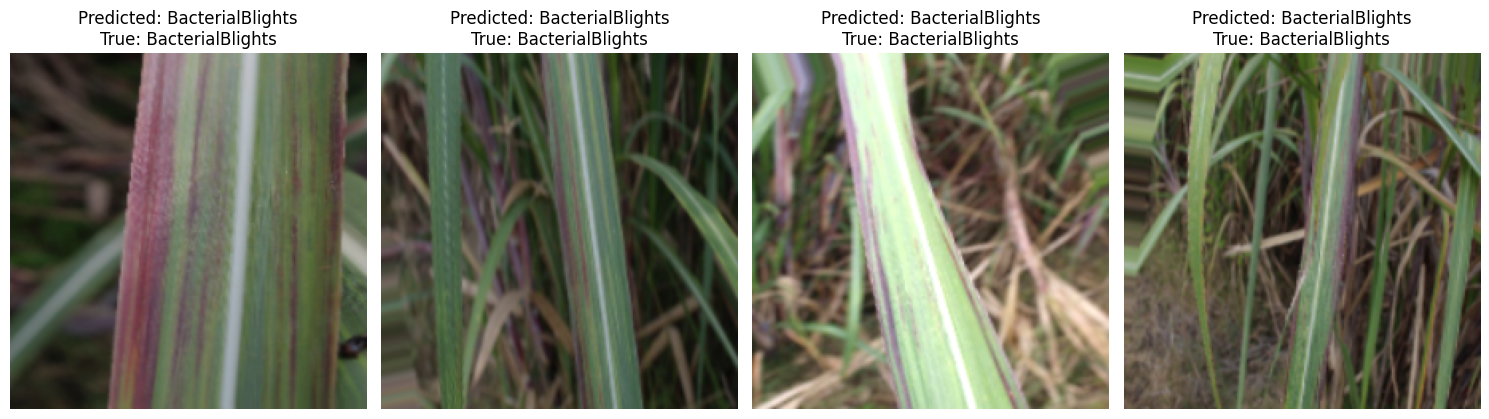

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to show an image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    # Unnormalize if necessary
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Hide axes for clarity

# Get a batch of validation data
inputs, classes = next(iter(val_loader))

# Move inputs and labels to the device
inputs = inputs.to(device)
classes = classes.to(device)

# Set model to evaluation mode
model.eval()

# Make predictions without tracking gradients
with torch.no_grad():
    # Obtain the outputs from the model
    outputs = model(inputs)

    # **Extract the logits Tensor from the outputs**
    outputs = outputs.logits  # Access the 'logits' attribute

    # Get the predicted classes
    _, preds = torch.max(outputs, 1)

# Move data to CPU for visualization
inputs = inputs.cpu()
classes = classes.cpu()
preds = preds.cpu()

# Get class names
class_names = val_dataset.classes  # Use validation dataset's classes

# Number of images to display
num_images = 4

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15, 6))
for idx in range(num_images):
    ax = fig.add_subplot(1, num_images, idx+1)
    imshow(inputs[idx])

    # Get class names using class indices
    pred_class = class_names[preds[idx]]
    true_class = class_names[classes[idx]]

    # Set the title with predicted and true labels
    ax.set_title(f"Predicted: {pred_class}\nTrue: {true_class}")
    ax.axis('off')  # Hide axes ticks

plt.tight_layout()
plt.show()

In [ ]:
import torch
from PIL import Image
import warnings
from torchvision import transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor

warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

# Load the saved model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=6)
model.load_state_dict(torch.load('/kaggle/working/vit_sugarcane_disease_detection.pth'))
model.eval()

# Define the same transformation used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the class names (disease types)
class_names = ['BacterialBlights', 'Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']

# Function to predict disease type from an image
def predict_disease(image_path):
    # Open the image file
    img = Image.open(image_path)

    # Apply transformations to the image
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted_class = torch.max(outputs.logits, 1)

    # Get the predicted label
    predicted_label = class_names[predicted_class.item()]

    return predicted_label

# Test with a new image
image_path = '/kaggle/input/sugarcane-test-images/zoomed_healthy (9).jpeg'  # Replace with your image path
predicted_label = predict_disease(image_path)
print(f'The predicted disease type is: {predicted_label}')





Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-27-3ea64040ffa3>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

The predicted disease type is: Healthy


In [ ]:
checkpoint = torch.load('/kaggle/working/vit_sugarcane_disease_detection.pth')
print(checkpoint.keys())  # Check what keys are in the saved state dict


<ipython-input-14-841930334e5d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/vit_sugarcane_disease_detection.pth')


odict_keys(['vit.embeddings.cls_token', 'vit.embeddings.position_embeddings', 'vit.embeddings.patch_embeddings.projection.weight', 'vit.embeddings.patch_embeddings.projection.bias', 'vit.encoder.layer.0.attention.attention.query.weight', 'vit.encoder.layer.0.attention.attention.query.bias', 'vit.encoder.layer.0.attention.attention.key.weight', 'vit.encoder.layer.0.attention.attention.key.bias', 'vit.encoder.layer.0.attention.attention.value.weight', 'vit.encoder.layer.0.attention.attention.value.bias', 'vit.encoder.layer.0.attention.output.dense.weight', 'vit.encoder.layer.0.attention.output.dense.bias', 'vit.encoder.layer.0.intermediate.dense.weight', 'vit.encoder.layer.0.intermediate.dense.bias', 'vit.encoder.layer.0.output.dense.weight', 'vit.encoder.layer.0.output.dense.bias', 'vit.encoder.layer.0.layernorm_before.weight', 'vit.encoder.layer.0.layernorm_before.bias', 'vit.encoder.layer.0.layernorm_after.weight', 'vit.encoder.layer.0.layernorm_after.bias', 'vit.encoder.layer.1.atten

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
import warnings
import sys
import os
import contextlib
from transformers import ViTForImageClassification

# Suppress warnings related to the model weights initialization, FutureWarning and UserWarnings
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")
warnings.filterwarnings("ignore", category=FutureWarning, module="torch")

# Suppress output for copying files and verbose model initialization messages
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# Load the saved model and suppress the warnings
with suppress_stdout():
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=6)
    model.load_state_dict(torch.load('/kaggle/working/vit_sugarcane_disease_detection.pth'))
    model.eval()

# Define the same transformation used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the class names (disease types)
class_names = ['BacterialBlights', 'Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']

# Function to predict disease type from an image
def predict_disease(image_path):
    # Open the image file
    img = Image.open(image_path)

    # Apply transformations to the image
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted_class = torch.max(outputs.logits, 1)

    # Get the predicted label
    predicted_label = class_names[predicted_class.item()]

    return predicted_label

# Test with a new image
image_path = '/kaggle/input/sugarcane-test-images/zoomed_healthy (9).jpeg'  # Replace with your image path
predicted_label = predict_disease(image_path)
print(f'The predicted disease type is: {predicted_label}')



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-31-290d128e2c1e>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

The predicted disease type is: Healthy


In [ ]:
pip freeze


absl-py==1.4.0
accelerate==0.34.2
aiofiles==22.1.0
aiohappyeyeballs==2.4.0
aiohttp==3.10.5
aiosignal==1.3.1
aiosqlite==0.20.0
alabaster==0.7.16
albucore==0.0.16
albumentations==1.4.15
alembic==1.14.0
altair==5.5.0
annotated-types==0.7.0
annoy==1.17.3
ansicolors==1.1.8
antlr4-python3-runtime==4.9.3
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
args==0.1.0
array_record==0.5.1
arrow==1.3.0
arviz==0.19.0
astropy==6.1.3
astropy-iers-data==0.2024.9.16.0.32.21
asttokens==3.0.0
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
bayesian-optimization==2.0.1
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.17.0
bigquery-magics==0.2.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blobfile==3.0.0
blosc2==2.0.0
bokeh==3.4.3
Boruta==0.4.3
boto3==1.35.83
botocore==1.35.83
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_helper
bqplot==0.12.43
branca==0.7.2
b